In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_4DLorenz.recursive_Markovian_PostMeanScore_4DLorenz_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
num_paths = 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [3]:
def get_drift_files(config):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/4DLnz/"
    global_files = []
    true_files = []
    local_files = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "local" in file:
                local_files.append(root_nadaraya_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws

In [4]:
config = get_config()
true_files, local_files, bws = get_drift_files(config=config)
local_files

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_1e-05bw_10240NPaths_00t0_3906e-03dT_075FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_13e-05bw_10240NPaths_00t0_3906e-03dT_075FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_17e-05bw_10240NPaths_00t0_3906e-03dT_075FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_22e-05bw_10240NPaths_00t0_3906e-03dT_075FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_28e-05bw_10240NPaths_00t0_3906e-03dT_075FConst_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_f4DLnz_DriftTrack_36e-05bw_10240NPaths_00t0_3906e-03dT_075FConst_local_

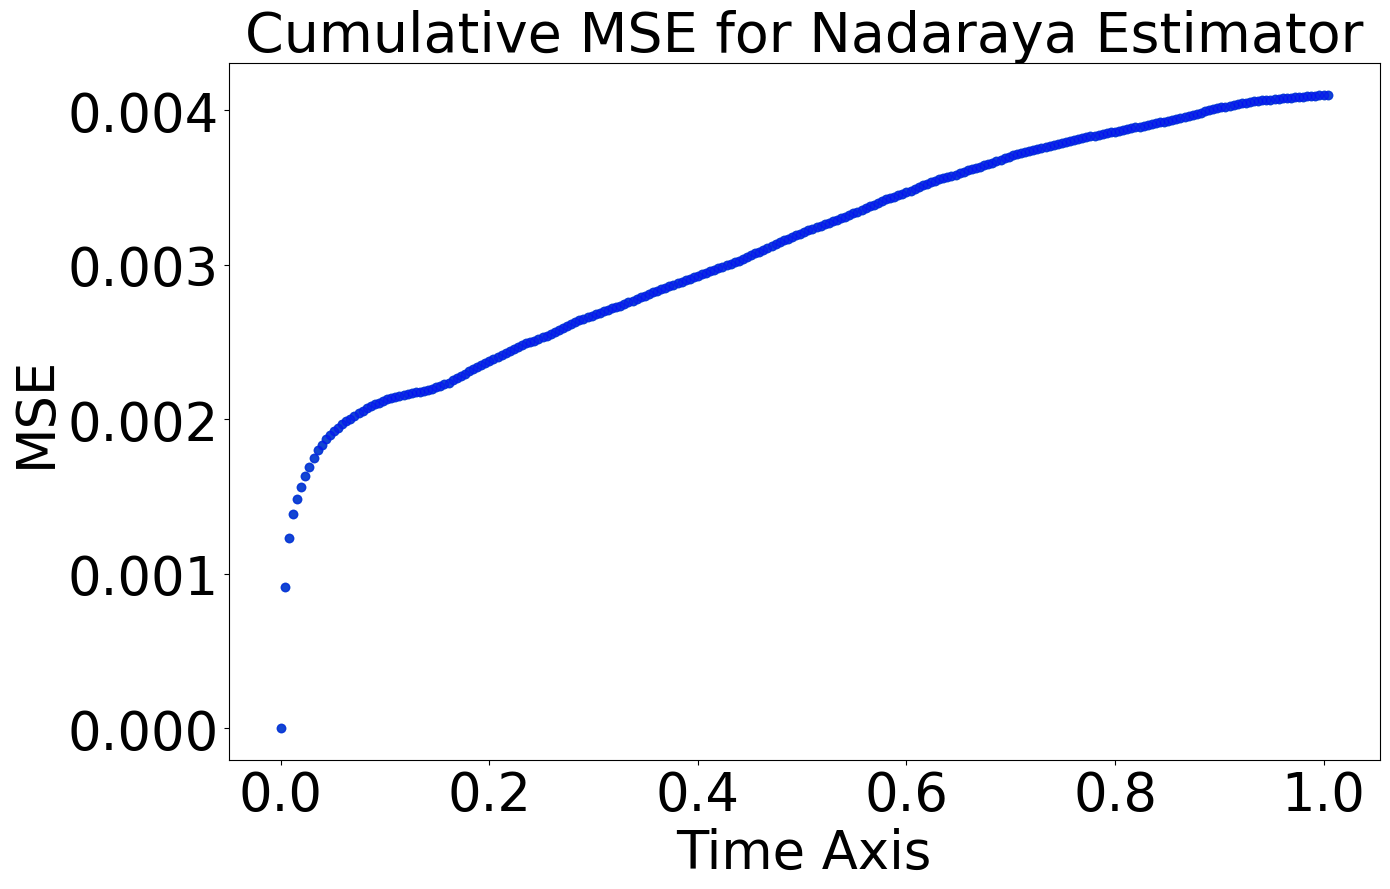

Final time cumulative MSE local-time error 0.004099246660957431 with IQR ((0.004099246660957432, 0.004099246660957432))at bw 1e-06 for 0.75FConst

Bandwidth, Error Mean, Error IQR, CurrMSE (1, 1e-06, 0.004099246660957431, 0.0, 0.004099246660957431)

Bandwidth, Error Mean, Error IQR, CurrMSE (2, 1.3e-06, 0.004099246660957431, 0.0, 0.004099246660957431)

Bandwidth, Error Mean, Error IQR, CurrMSE (3, 1.7e-06, 0.004099246660957431, 0.0, 0.004099246660957431)

Bandwidth, Error Mean, Error IQR, CurrMSE (4, 2.2e-06, 0.004099246660957431, 0.0, 0.004099246660957431)

Bandwidth, Error Mean, Error IQR, CurrMSE (5, 2.8e-06, 0.004099246660957431, 0.0, 0.004099246660957431)

Bandwidth, Error Mean, Error IQR, CurrMSE (6, 3.6e-06, 0.004099246660957431, 0.0, 0.004099246660957431)

Bandwidth, Error Mean, Error IQR, CurrMSE (7, 1e-05, 0.004226930075743491, 0.0, 0.004099246660957431)

Bandwidth, Error Mean, Error IQR, CurrMSE (8, 1.19e-05, 0.004238938936603952, 0.0, 0.004099246660957431)

Bandwidth, Error

In [7]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])/np.sqrt(config.deltaT)
    all_local_states = np.load(file[1])/np.sqrt(config.deltaT)
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        total_local_errors_minq = np.quantile((all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile((all_local_errors), axis=0,q=0.975)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            miny = total_local_errors-total_local_errors_minq
            miny[miny < 0.] = 0.
            maxy = total_local_errors_maxq-total_local_errors
            maxy[maxy < 0.] = 0.
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            plt.errorbar(time_steps,total_local_errors,yerr=[miny, maxy],xerr=None, fmt='o', color="blue", alpha=0.4)
            ax.set_title(f"Cumulative MSE for Nadaraya Estimator",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir+f"DiffusionModelPresentationImages/IIDNadaraya_4DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")
        print(f"Bandwidth, Error Mean, Error IQR, CurrMSE {i, bw, total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse}\n")